In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [2]:
import ee

import pandas as pd
import numpy as np
import seaborn as sns

from ast import literal_eval
from dfply import *

import geopandas as gpd

import plotnine
from plotnine import *
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import itertools

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
import requests
from shapely.geometry import Polygon,MultiPolygon,shape
import io
import ast

NCP_gee_path = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")
NCP_url = NCP_gee_path.getDownloadURL()
NCP_rep = requests.get(NCP_url)
NCP_shp = pd.read_csv(io.StringIO(NCP_rep.text))
NCP_shp['geometry'] = NCP_shp['.geo'].apply(lambda x:shape(ast.literal_eval(x)))
NCP_shp = NCP_shp.set_geometry('geometry')

The possible SSP-RCP combinations <br>
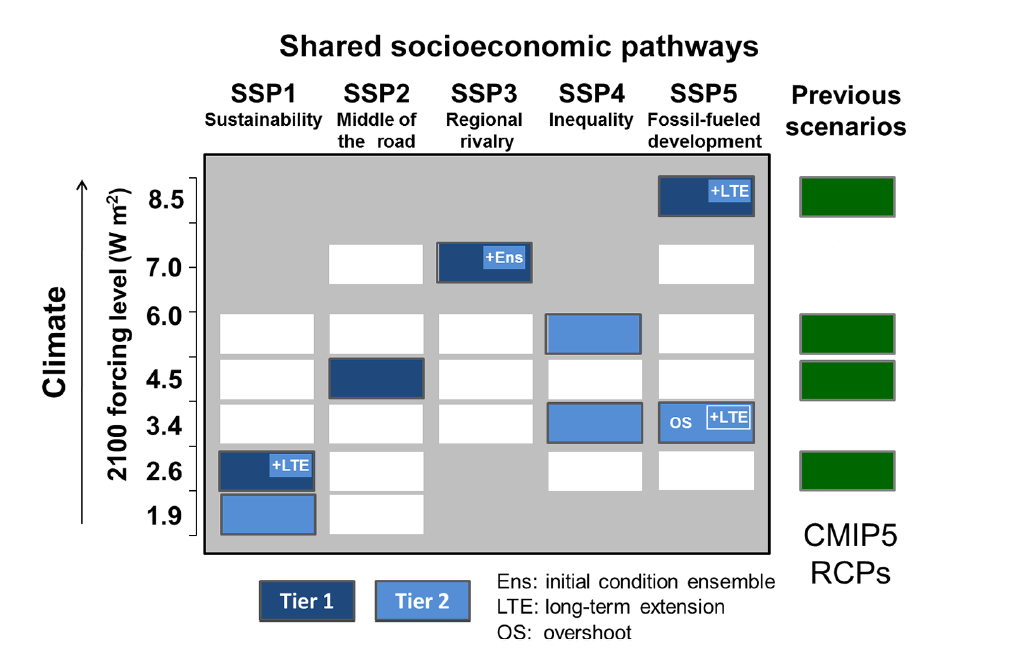

In [5]:
# copose the rules to select valid SSP-RCP combinations
rules = '''((X.ssp == 'SSP1')&(X.rcp == '26'))|
       ((X.ssp == 'SSP2')&(X.rcp == '45'))|
       ((X.ssp == 'SSP3')&(X.rcp == '60'))|
       ((X.ssp == 'SSP5')&(X.rcp == '85'))'''

rules = rules.replace('\n','').replace(' ','')

#### 1) the general pattern: Climate/Tech/Urbanization impacts on food production

In [6]:
# read the accumulative sum
prod_actual_with_climate_tech_urban_reclamation = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/prod_actual_with_climate_tech_reclamation_urban.csv')

In [7]:
# filter to get a df for plotting
df = prod_actual_with_climate_tech_urban_reclamation >> mask(X.ssp=='SSP2',X.rcp==45)
df.head()

,rcp,ssp,year,Total Production sd,actual_x_min,actual_x_max,actual_y_min,actual_y_max,color_final,gap_climate,...,gap_urban,gap_urban_sd,urban_x_min,urban_x_max,urban_y_min,urban_y_max,color_climate,color_tech,color_reclamation,color_urban
81,45,SSP2,2020,8075.827649,2019.375,2020.625,0,210702.177484,Final,-1997.136586,...,8590.103031,9247.794073,2024.375,2025.625,223620.387495,215030.284464,Climate,Technology,Reclamation,Urban
86,45,SSP2,2025,7912.583800,2024.375,2025.625,0,214920.636656,Final,126.261736,...,7915.855084,12944.224947,2029.375,2030.625,230786.416688,222870.561604,Climate,Technology,Reclamation,Urban
91,45,SSP2,2030,10453.840302,2029.375,2030.625,0,222733.008156,Final,124.392118,...,6731.432157,16734.104411,2034.375,2035.625,237100.053714,230368.621557,Climate,Technology,Reclamation,Urban
96,45,SSP2,2035,10367.621684,2034.375,2035.625,0,230301.730328,Final,124.379990,...,5931.168379,20816.566368,2039.375,2040.625,242419.681224,236488.512846,Climate,Technology,Reclamation,Urban
101,45,SSP2,2040,10327.247418,2039.375,2040.625,0,236451.799587,Final,125.608330,...,5142.299001,25040.658446,2044.375,2045.625,249412.116499,244269.817498,Climate,Technology,Reclamation,Urban


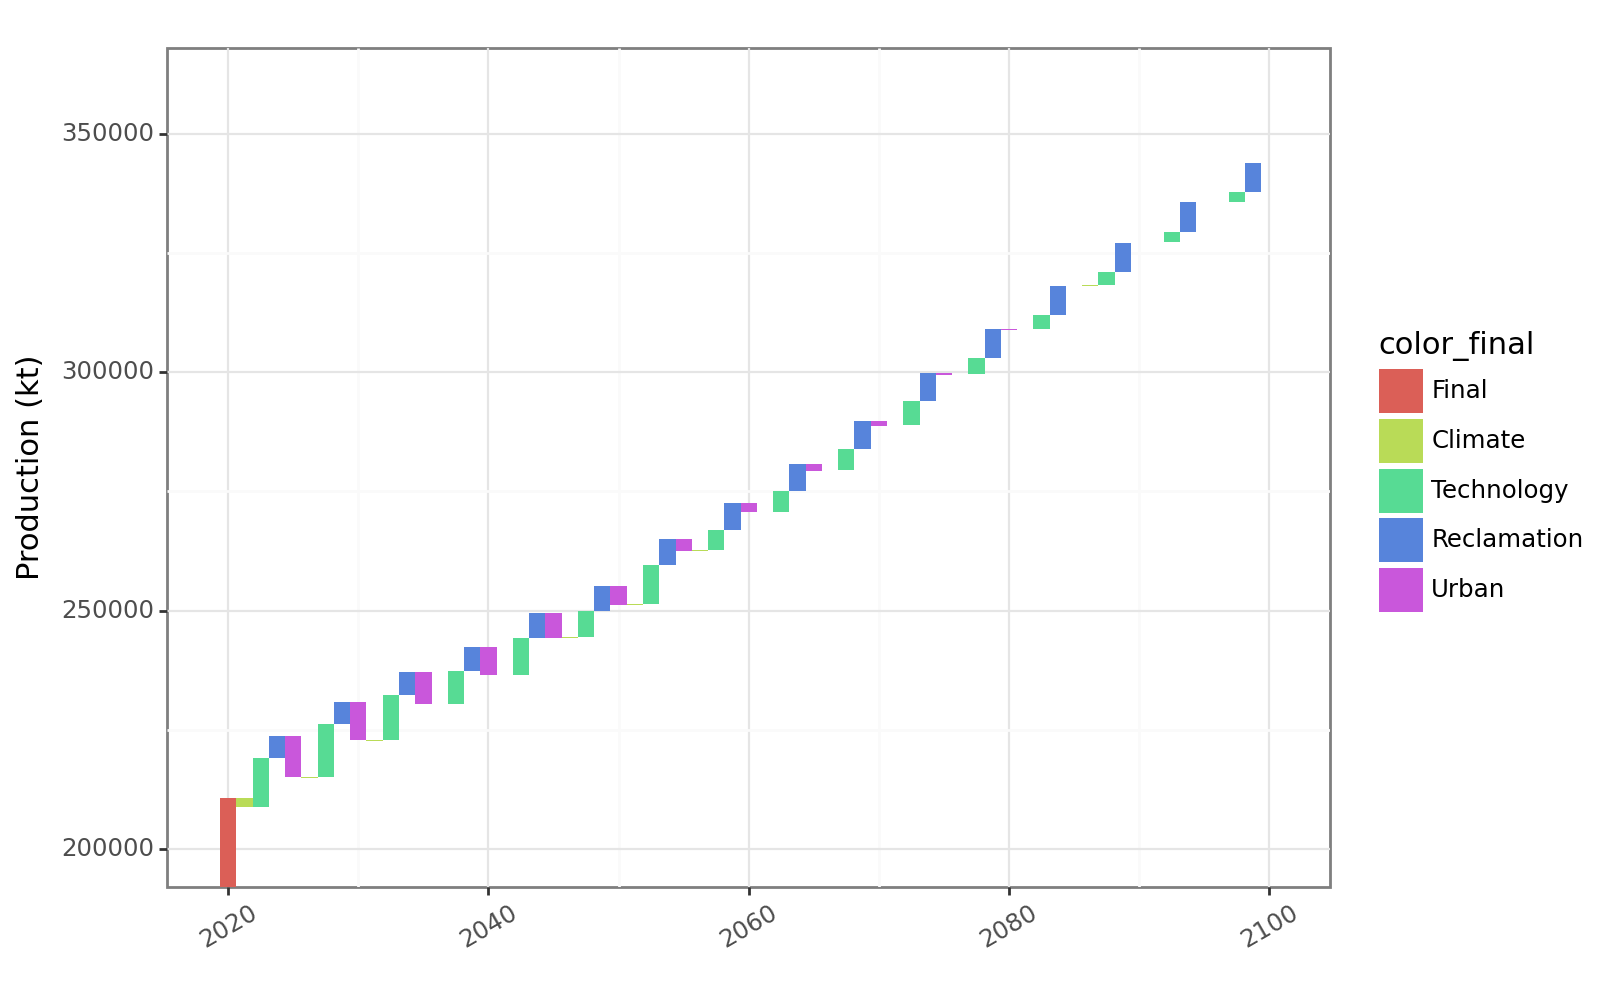

<Figure Size: (800 x 500)>

In [8]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (8, 5)
plotnine.options.dpi = 100

(ggplot() +
  # final production
  geom_rect(df >> mask((X.year == 2020)), 
          aes(xmin='actual_x_min',xmax='actual_x_max', 
            ymin='actual_y_min',ymax='actual_y_max',fill='color_final')) +
  # climate production gap
  geom_rect(df, aes(xmin='climate_x_min',xmax='climate_x_max',
           ymin='climate_y_min',ymax='climate_y_max',fill='color_climate')) +
  # tech gap
  geom_rect(df, aes(xmin='tech_x_min',xmax='tech_x_max',
           ymin='tech_y_min',ymax='tech_y_max',fill='color_tech')) +
  # reclamation gap
  geom_rect(df, aes(xmin='reclamation_x_min',xmax='reclamation_x_max',
           ymin='reclamation_y_min',ymax='reclamation_y_max',fill='color_reclamation')) +
  # urban gap
  geom_rect(df, aes(xmin='urban_x_min',xmax='urban_x_max',
           ymin='urban_y_min',ymax='urban_y_max',fill='color_urban')) +
  # ----------------------------------------------------------------------------------
  # scale_fill_manual(values={'Final':'grey','Climate':'#ffd639','Technology':'#279af1','Urban':'#9e2a2b','Reclamation':'#cf70dd'},
  #          name='Contributions') +
  coord_cartesian(ylim=(200000,360000)) +
  theme_bw() + 
  theme(axis_text_x=element_text(rotation=30)) +
  ylab('Production (kt)') 
  )

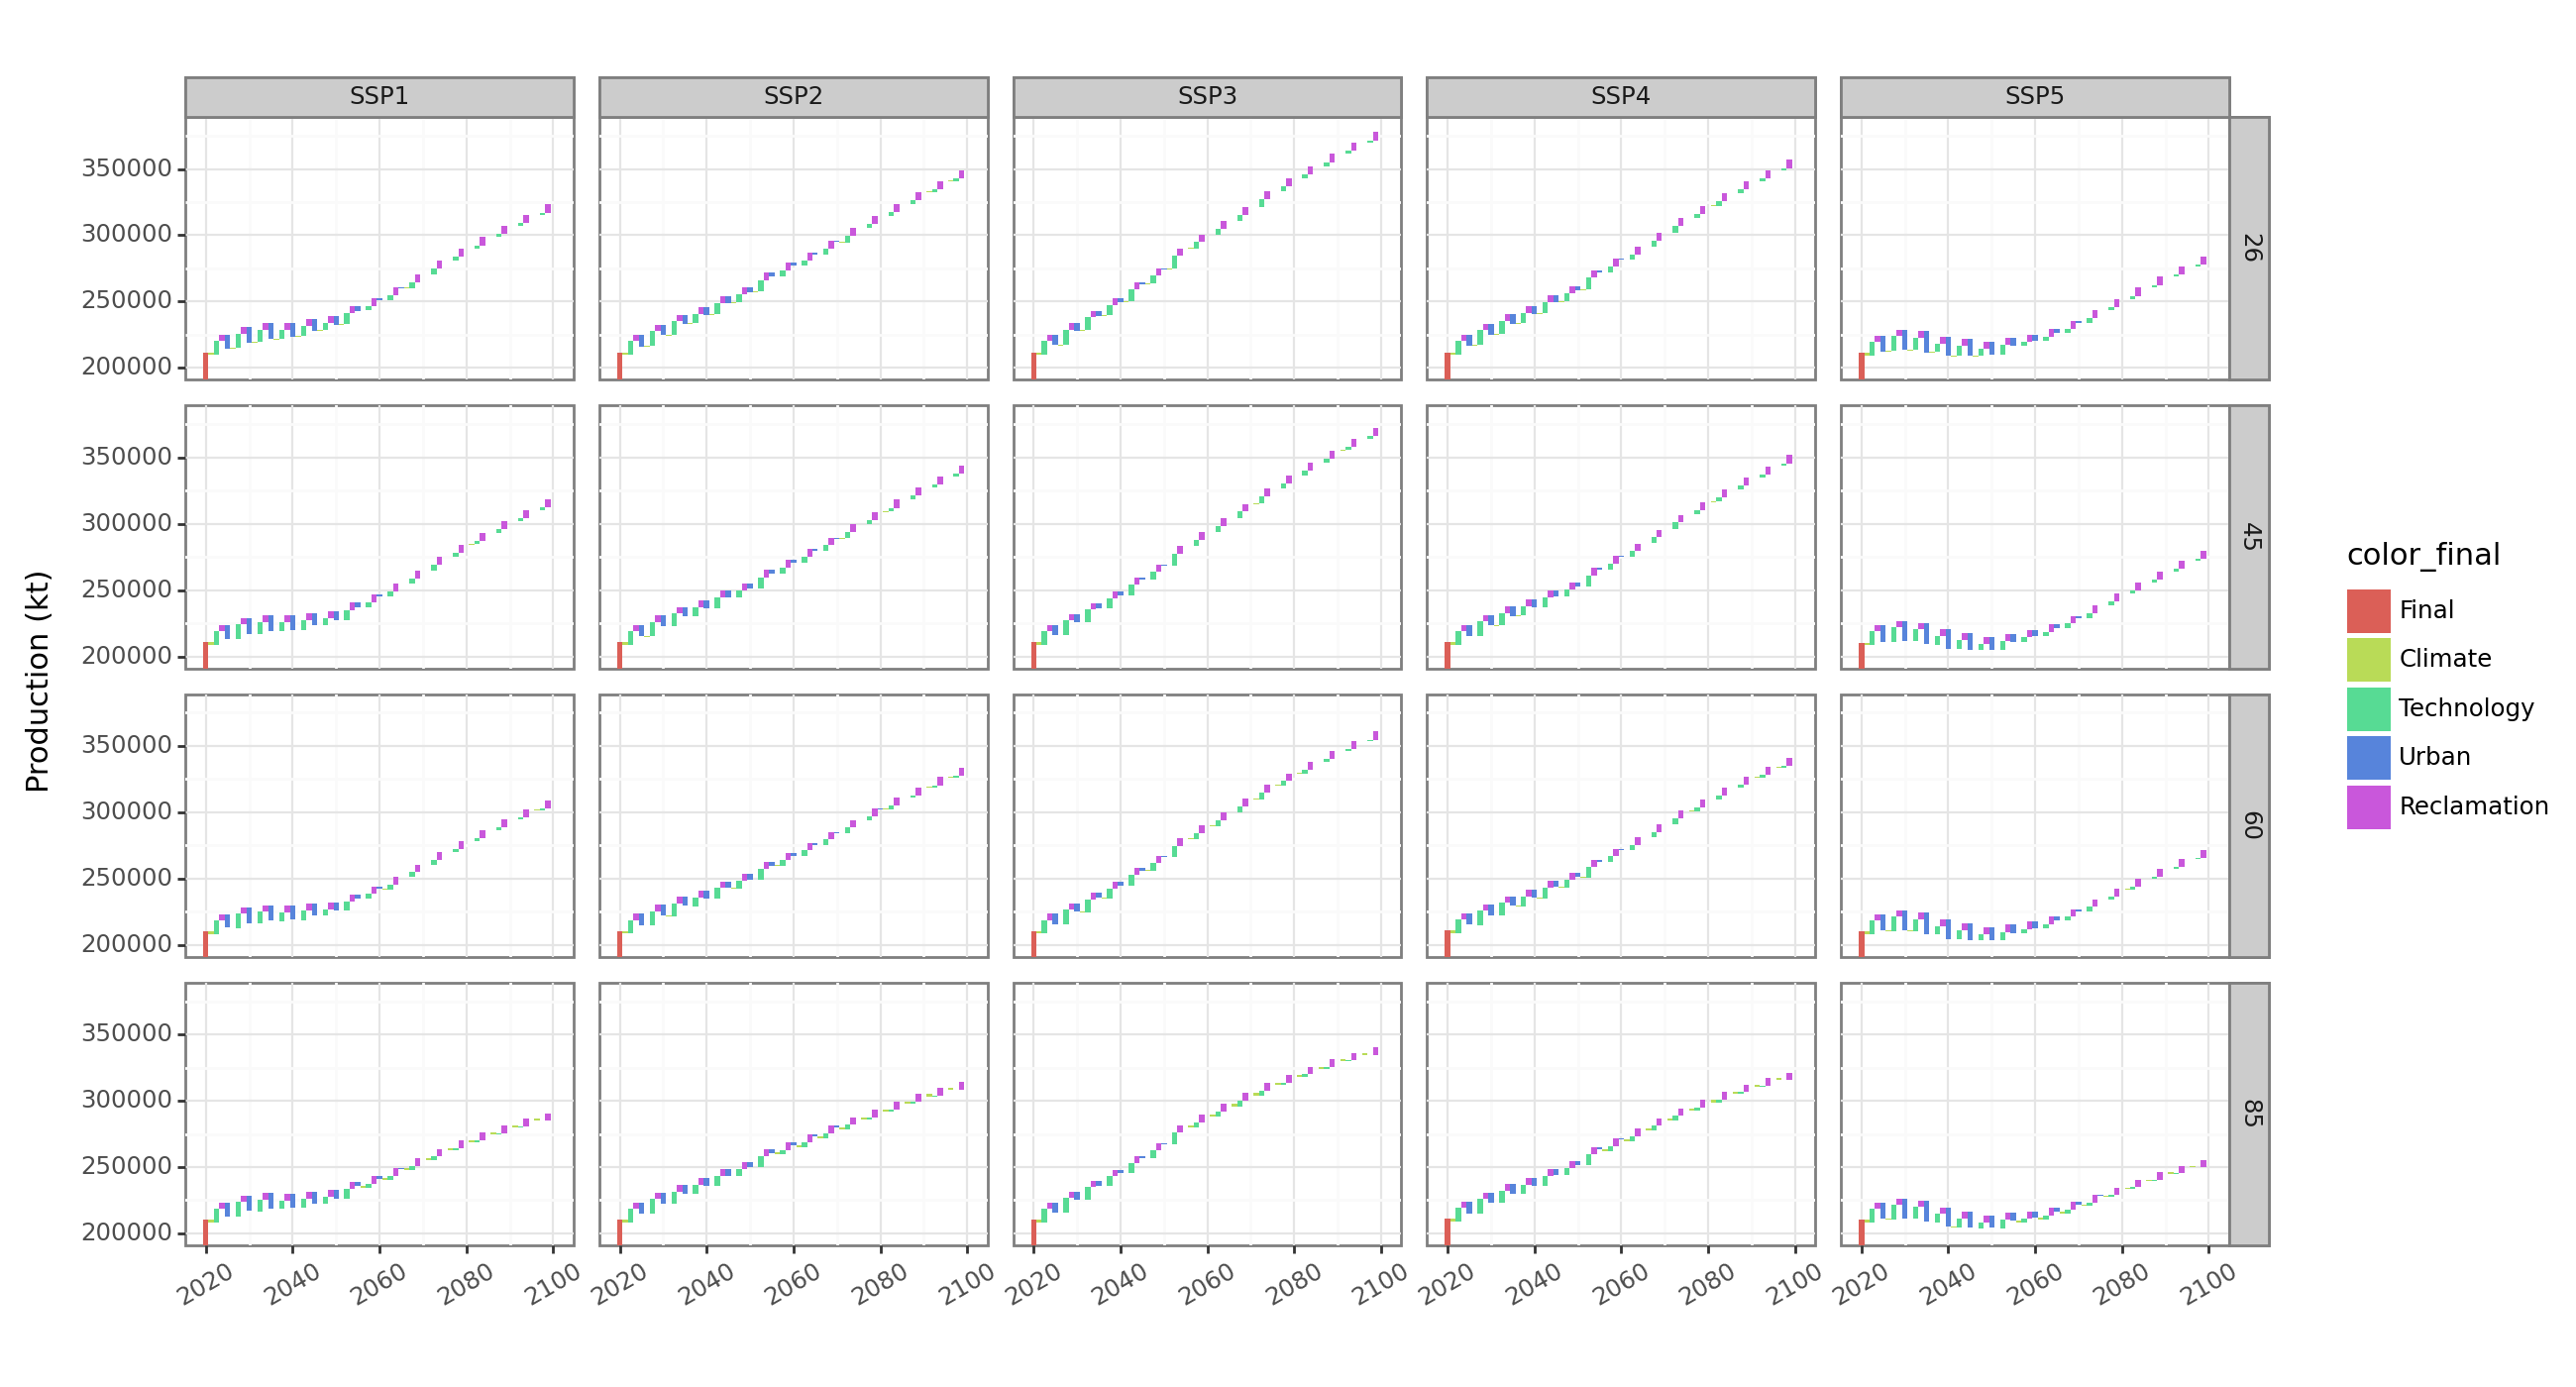

<Figure Size: (1300 x 700)>

In [9]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (13, 7)
plotnine.options.dpi = 100

(ggplot() +
#  # actual production
#  geom_col(pred_actual_production_sum_df_select,aes(x='year',y='Total Production'),alpha=0.1) +
  # start/end year
 geom_rect(prod_actual_with_climate_tech_urban_reclamation >> mask(X.year == 2020), 
           aes(xmin='actual_x_min',xmax='actual_x_max', 
             ymin='actual_y_min',ymax='actual_y_max',fill='color_final')) +
 # climate production gap
 geom_rect(prod_actual_with_climate_tech_urban_reclamation, 
           aes(xmin='climate_x_min',xmax='climate_x_max',ymin='climate_y_min',
             ymax='climate_y_max',fill='color_climate')) +
 # tech gap
 geom_rect(prod_actual_with_climate_tech_urban_reclamation, 
           aes(xmin='tech_x_min',xmax='tech_x_max',ymax='tech_y_max',
             ymin='tech_y_min',fill='color_tech')) +
 # urban gap
 geom_rect(prod_actual_with_climate_tech_urban_reclamation,  
           aes(xmin='urban_x_min',xmax='urban_x_max',ymin='urban_y_min',
             ymax='urban_y_max',fill='color_urban')) +
 geom_rect(prod_actual_with_climate_tech_urban_reclamation,  
      aes(xmin='reclamation_x_min',xmax='reclamation_x_max',
        ymin='reclamation_y_min',ymax='reclamation_y_max',fill='color_reclamation')) +
 # ---------------------------------------------------------------------------------- 
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
#  scale_fill_manual(values={'Final':'grey','Climate':'#ffd639','Technology':'#279af1','Urban':'#9e2a2b','Reclamation':'#cf70dd'},
#            name='Contributions') +
 coord_cartesian(ylim=(200000,380000)) +
 ylab('Production (kt)') +
 facet_grid('rcp~ssp')
)

#### 2) Seperate the impacts on food production:
- [climate,tech,urban] impacts on total food production production
- [crop,water] impacts on net production change.

In [10]:
# final productoin
pred_actual_production_df_cities = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/pred_actual_production_df_cities.csv')\
                  >> rename(Predict_production = 'Total Production',Predict_production_sd = 'Total Production sd')
# the climate impacts
climate_production_df_cites = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/climate_production_df_cites.csv')\
                  >> rename(Climate_gap = 'Gap Production',Climate_gap_sd = 'Gap Production sd')
# the technology impacts
tech_production_df_cites = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/tech_production_df_cites.csv')\
                  >> rename(Tech_gap = 'Gap Production', Tech_gap_sd = 'Gap Production sd')
# the reclamation impacts
reclamation_production_df_cites = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/reclamation_production_df_cites.csv')\
                  >> rename(Reclamation_gap = 'Gap Production', Reclamation_gap_sd = 'Gap Production sd')
# the urbanization impacts
urban_production_df_cites = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/urban_production_df_cites.csv')\
                  >> rename(Urban_gap = 'Gap Production', Urban_gap_sd = 'Gap Production sd')

#  urban_gap: make the gap negative
urban_production_df_cites['Urban_gap'] = -urban_production_df_cites['Urban_gap']

# merge all production dfs
production_with_impact_gaps = pred_actual_production_df_cities\
                .merge(climate_production_df_cites)\
                .merge(tech_production_df_cites)\
                .merge(reclamation_production_df_cites)\
                .merge(urban_production_df_cites)
           

In [11]:
# out_dfs = []
# grouped_df = production_with_impact_gaps.groupby(['Province','crop','water','rcp','ssp'])

# for idx,df in tqdm(grouped_df,total=len(grouped_df)):

#   # copy input_df
#   out_df = df.copy().sort_values('year')
#   out_df['final_year'] = df['year'] + 5

#   # get the production in 2020
#   prod_2020 = df[df['year']==2020]['Predict_production'].tolist()[0]

#   # compute the accumulate climate/tech impacts
#   out_df['accum_climate'] = out_df['Climate_gap'].cumsum()
#   out_df['accum_tech'] = out_df['Tech_gap'].cumsum()
#   out_df['accum_reclamation'] = out_df['Reclamation_gap'].cumsum()
#   out_df['accum_urban'] = out_df['Urban_gap'].cumsum()
  

#   # compute the confidence interval of accumulated impacts
#   out_df['accum_climate_bot'] = out_df['accum_climate'] - out_df['Climate_gap_sd']
#   out_df['accum_climate_top'] = out_df['accum_climate'] + out_df['Climate_gap_sd']
#   out_df['accum_tech_bot'] = out_df['accum_tech'] - out_df['Tech_gap_sd']
#   out_df['accum_tech_top'] = out_df['accum_tech'] + out_df['Tech_gap_sd']
#   out_df['accum_reclamation_bot'] = out_df['accum_reclamation'] - out_df['Reclamation_gap_sd']
#   out_df['accum_reclamation_top'] = out_df['accum_reclamation'] + out_df['Reclamation_gap_sd']
#   out_df['accum_urban_bot'] = out_df['accum_urban'] - out_df['Urban_gap_sd']
#   out_df['accum_urban_top'] = out_df['accum_urban'] + out_df['Urban_gap_sd']


#   # compute the final values imposed by climate/tech/urban/reclamation chronologicall
#   gaps_all = np.array([list(pair) for pair in zip(out_df['Climate_gap'],out_df['Tech_gap'],
#                              out_df['Urban_gap'],out_df['Reclamation_gap'])]).flatten()
#   gaps_all = np.insert(gaps_all,0,prod_2020)

#   gaps_chronologically = np.cumsum(gaps_all).tolist()[1:]

#   out_df['final_climate'] = gaps_chronologically[0::4]
#   out_df['final_tech'] = gaps_chronologically[1::4]
#   out_df['final_urban'] = gaps_chronologically[2::4]
#   out_df['final_reclamation'] = gaps_chronologically[3::4]

#   # get the uncertianties
#   out_df['final_climate_bot'] = out_df['final_climate'] - out_df['Climate_gap_sd']
#   out_df['final_climate_top'] = out_df['final_climate'] + out_df['Climate_gap_sd']
#   out_df['final_tech_bot'] = out_df['final_tech'] - out_df['Tech_gap_sd']
#   out_df['final_tech_top'] = out_df['final_tech'] + out_df['Tech_gap_sd']
#   out_df['final_reclamation_bot'] = out_df['final_reclamation'] - out_df['Reclamation_gap_sd']
#   out_df['final_reclamation_top'] = out_df['final_reclamation'] + out_df['Reclamation_gap_sd']
#   out_df['final_urban_bot'] = out_df['final_urban'] - out_df['Urban_gap_sd']
#   out_df['final_urban_top'] = out_df['final_urban'] + out_df['Urban_gap_sd']
  
#   # record the columns
#   out_df = out_df[['crop','water','Province','rcp', 'ssp', 'year','final_year',
#             'accum_climate','accum_climate_bot','accum_climate_top',
#             'accum_tech','accum_tech_bot','accum_tech_top',
#             'accum_urban','accum_urban_bot','accum_urban_top',
#             'accum_reclamation','accum_reclamation_bot','accum_reclamation_top',
#             'final_climate','final_climate_bot','final_climate_top',
#             'final_tech','final_tech_bot','final_tech_top',
#             'final_reclamation','final_reclamation_bot','final_reclamation_top',
#             'final_urban','final_urban_bot','final_urban_top']]

#   out_dfs.append(out_df)

  
# # concat all dfs in the list and save to disk
# production_city_crop_water_without_2020 = pd.concat(out_dfs).reset_index(drop=True)

In [12]:
# # get the production in 2020
# production_with_impact_gaps_2020 = production_with_impact_gaps \
#                     >> mask(X.year == 2020)\
#                     >> select(['crop','water','Province','rcp', 'ssp', 'year',
#                           'Predict_production','Predict_production_sd'])\
#                     >> mutate(final_urban=X.Predict_production,
#                        final_urban_bot = X.Predict_production - X.Predict_production_sd,
#                        final_urban_top = X.Predict_production + X.Predict_production_sd)\
#                     >> rename(final_year = 'year') >> drop(['Predict_production','Predict_production_sd'])

# # append 2020 records to the production_city_crop_water
# production_city_crop_water = pd.concat([production_with_impact_gaps_2020,production_city_crop_water_without_2020])

In [13]:
# # compute the net total production change
# production_city_crop_water['net_change'] = production_city_crop_water['accum_climate'] \
#                         + production_city_crop_water['accum_tech'] \
#                         + production_city_crop_water['accum_urban'] \
#                         + production_city_crop_water['accum_reclamation']

# production_city_crop_water['net_change_bot'] = production_city_crop_water['accum_climate_bot'] \
#                         + production_city_crop_water['accum_tech_bot'] \
#                         + production_city_crop_water['accum_urban_bot'] \
#                         + production_city_crop_water['accum_reclamation']

# production_city_crop_water['net_change_top'] = production_city_crop_water['accum_climate_top'] \
#                         + production_city_crop_water['accum_tech_top'] \
#                         + production_city_crop_water['accum_urban_top'] \
#                         + production_city_crop_water['accum_reclamation']

# # add scenario col
# production_city_crop_water['rcp'] = production_city_crop_water['rcp'].astype(str)
# production_city_crop_water['Scenario'] = production_city_crop_water.apply(lambda x:f"{x['ssp']}-{x['rcp']}",1)


# # change kt to million t
# cols_change = list(set(production_city_crop_water.columns) 
#             - set(['crop', 'water', 'Province', 'rcp', 'ssp', 'year', 'final_year','Scenario']))
# production_city_crop_water[cols_change] = production_city_crop_water[cols_change]/1e3

# # save to disk
# production_city_crop_water.to_csv(f'./result_csv/production_city_crop_water.csv',index=False)

In [14]:
# read crop production change data
production_city_crop_water = pd.read_csv('./result_csv/production_city_crop_water.csv')
production_city_crop_water['rcp'] = production_city_crop_water['rcp'].astype(str)

# read population data
population = pd.read_csv('./result_csv/SSP_GDP_Pop_future_pred.csv')
population_total = population.groupby(['year','Scenario']).sum().reset_index() \
            >> rename(ssp='Scenario') \
            >> select(['ssp','year','Pop'])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16160\2757194502.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


##### 2-1) Compute the total and per capita crop production

Compute the per capita crop population form this study

In [15]:
# compute the total production aggregated from all cities (kt)
production_city_crop_water_total = production_city_crop_water.fillna(0).groupby(['rcp','ssp','year','final_year','Scenario'])\
                     .sum().reset_index()

# selecet the necessary cols
production_city_crop_water_total = production_city_crop_water_total\
                   >> mask(eval(rules))\
                   >> drop('year') >> rename(year='final_year')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16160\3352611553.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [16]:
# merge production with population
production_population_merge = production_city_crop_water_total.merge(population_total)

# compute the kt/person crop possesing 
production_population_merge['pp_production_kg'] = (production_population_merge['final_urban'] *1e6 * 1_000)\
                            /(production_population_merge['Pop'] * 10_000)
production_population_merge['pp_production_bot_kg'] = (production_population_merge['final_urban_bot'] *1e6 * 1_000)\
                            /(production_population_merge['Pop'] * 10_000)
production_population_merge['pp_production_top_kg'] = (production_population_merge['final_urban_top'] *1e6 * 1_000)\
                            /(production_population_merge['Pop'] * 10_000)

Compute the per capita crop population form yearbook

In [17]:
# the NCP provinces
NCP_provinces = ['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省']

In [18]:
# read the population data (10_000)
yearbook_pop = pd.read_csv('../Data/06_Yearbook/GDP_Population/yearbook_population_China.csv')
yearbook_pop = yearbook_pop.set_index('Province').stack().reset_index()
yearbook_pop.columns = ['Province','year','Pop']
yearbook_pop = yearbook_pop >> mask(X.Province.isin(NCP_provinces))
yearbook_pop['year'] = yearbook_pop['year'].astype(int)

# get the total population
yearbook_pop_total = yearbook_pop.groupby(['year'])['Pop'].sum().reset_index()

In [19]:
# dict to corresponding file_names to crops
crop_dict = {'maize':'Maize','wheat':'Wheat','rice':'Wetland_rice'}
yearbook_path = '../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield'

# get the yearbook production records
out_dfs = []
for k,v in crop_dict.items():
  df = pd.read_csv(f'{yearbook_path}/production_{k}.csv')
  df = df.set_index('地区').stack().reset_index()
  df.columns = ['Province','year','production_yearbook']
  df['production_yearbook'] = df['production_yearbook'] * 10_000
  df['year'] = df['year'].astype(int)
  df['crop'] = v
  out_dfs.append(df)

# add all crops together
yearbook_production = pd.concat(out_dfs).reset_index(drop=True) >> mask(X.Province.isin(NCP_provinces))

# t to million t
yearbook_production['production_yearbook'] = yearbook_production['production_yearbook']/1e6

# compute the total production
yearbook_production_total = yearbook_production.groupby(['year'])['production_yearbook'].sum().reset_index() >> mask(X.year >=1980)

# get the yearbook per capita production
yearbook_pp_production = yearbook_production_total.merge(yearbook_pop_total)
yearbook_pp_production['pp_production'] = (yearbook_pp_production['production_yearbook']* 1e6* 1_000) / (yearbook_pp_production['Pop']*10_000)

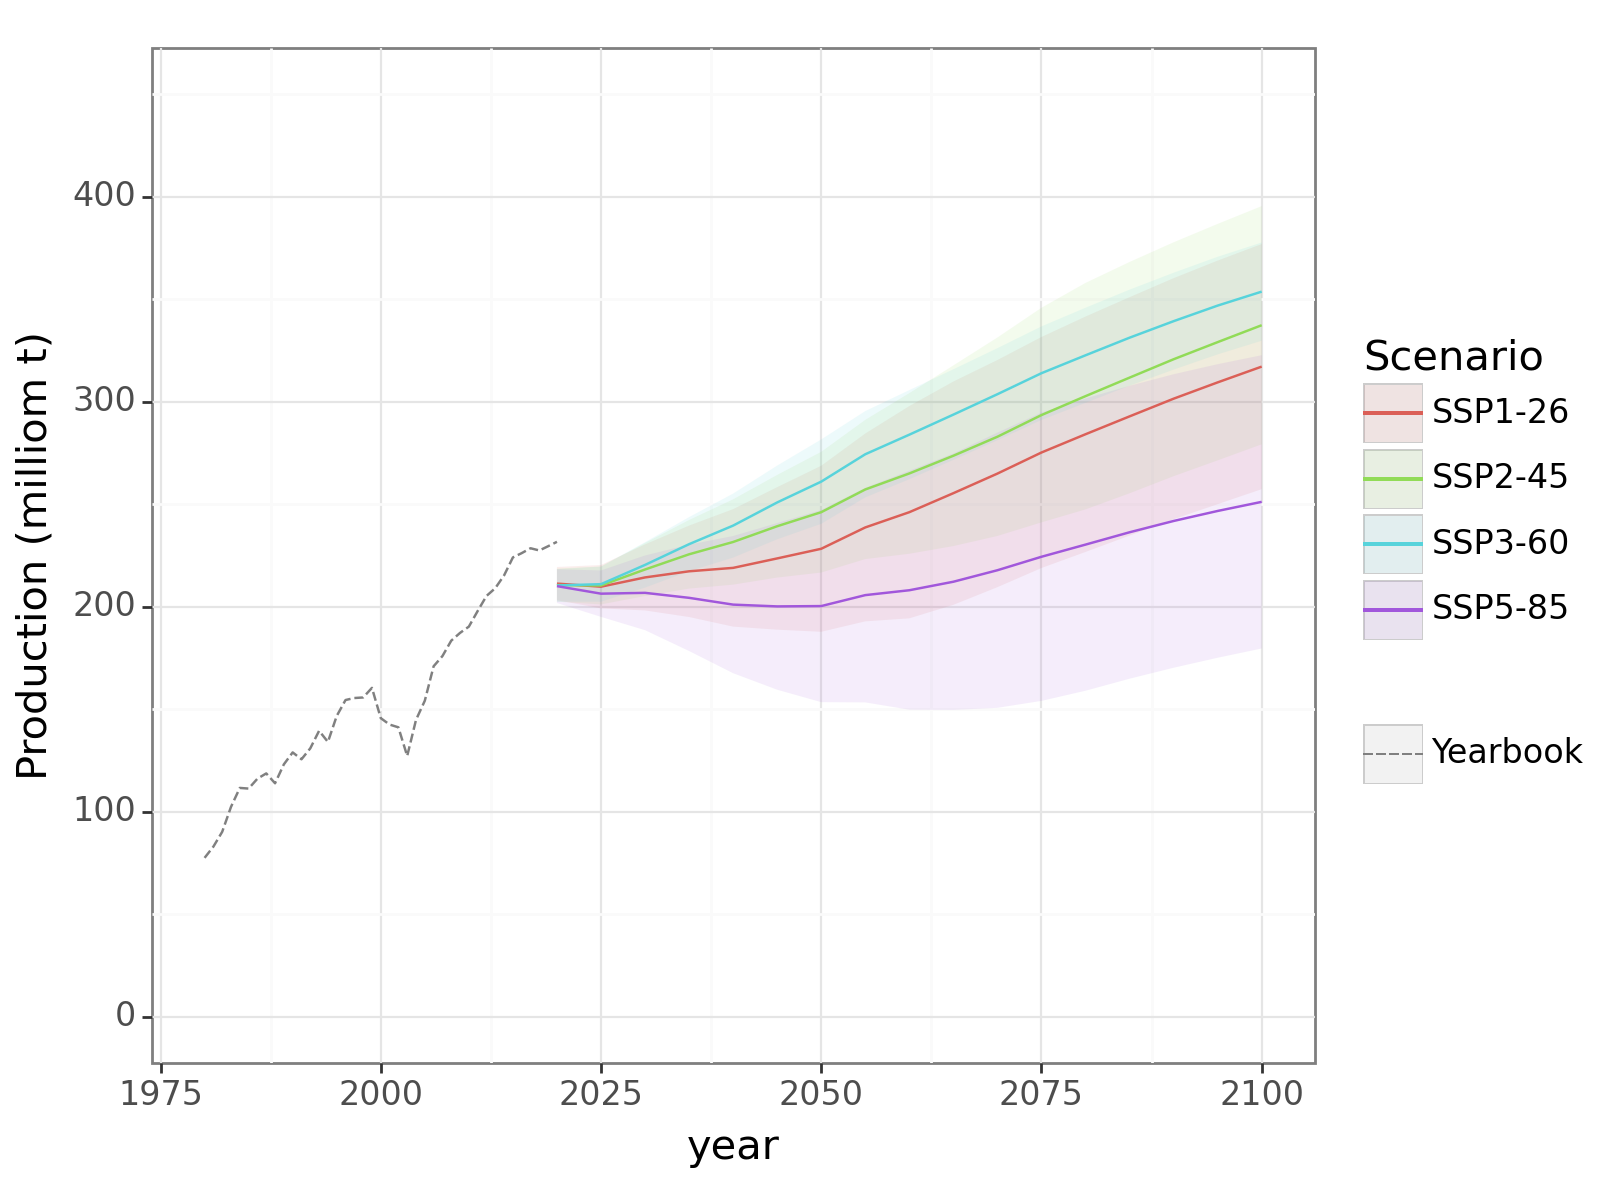

<Figure Size: (800 x 600)>

In [20]:
# plot the total production
plotnine.options.figure_size = (8, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # the model production
 geom_ribbon(production_population_merge,
         aes(x='year',ymin='final_urban_bot',ymax='final_urban_top',fill='Scenario'),alpha=0.1) +
 geom_line(production_population_merge,
     aes(x='year',y='final_urban',color='Scenario')) +
 # the yearbook production
 geom_line(yearbook_production_total,aes(x='year',y='production_yearbook',linetype=['Yearbook']*len(yearbook_production_total)),color='grey') +
 theme_bw(base_size=15) + 
 scale_fill_discrete() +
 scale_linetype_manual(values={'Yearbook':'dashed'},name=' ') +
 coord_cartesian(ylim=(0,450)) +
#  scale_x_continuous(breaks=range(2020,2101,25)) +
#  theme(axis_text_x=element_text(rotation=30)) +
 ylab('Production (milliom t)') 
)

# show fig
g

In [21]:
g.save('../Figs/result_3_1_total_production.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_1_total_production.svg


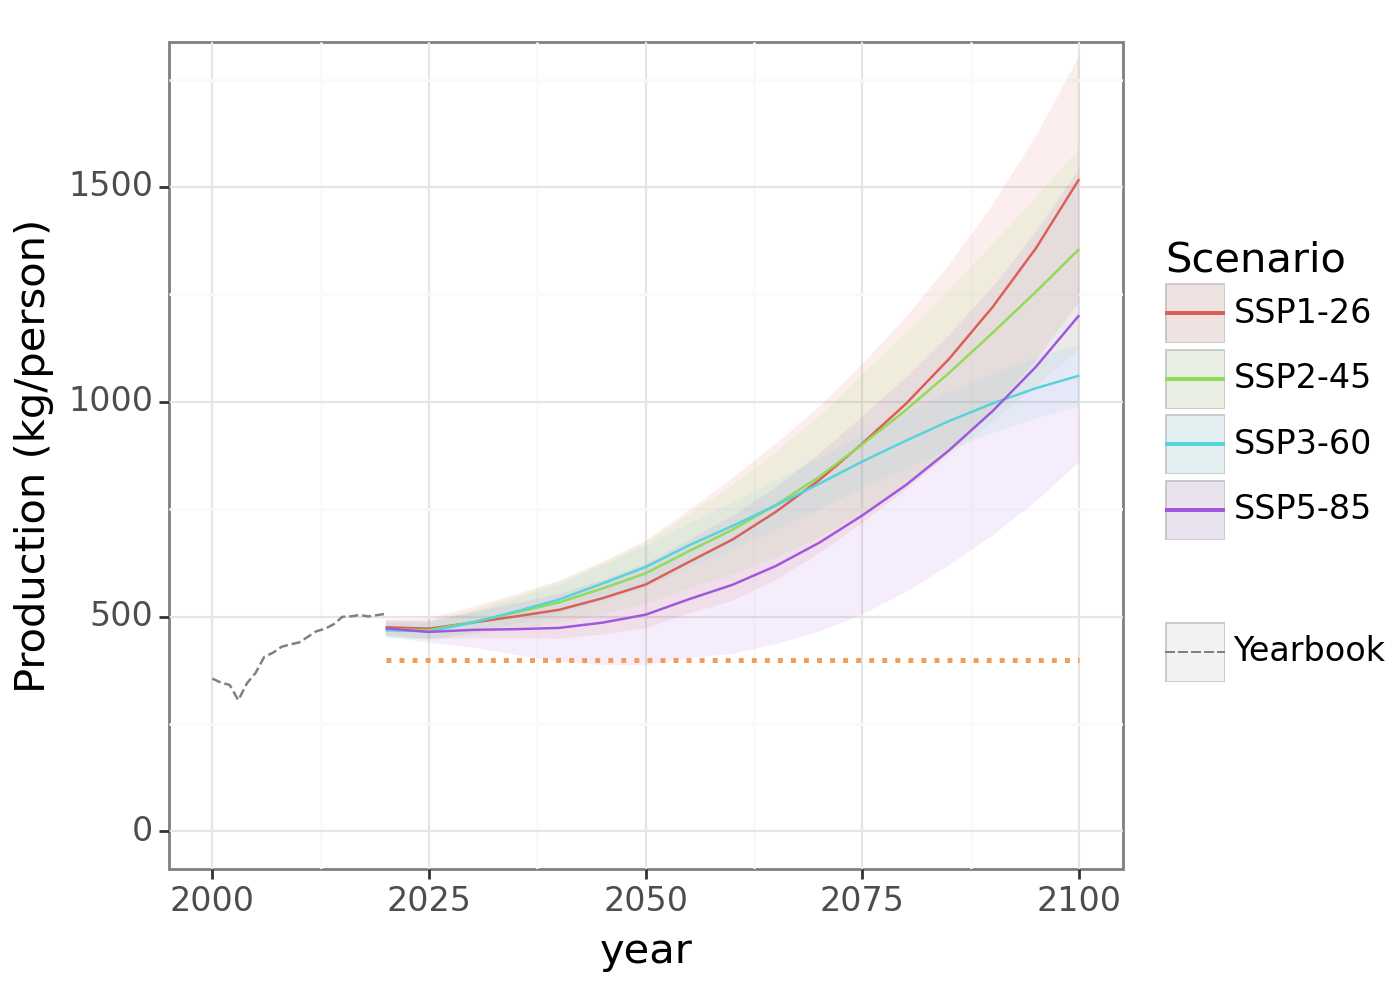

<Figure Size: (700 x 500)>

In [22]:
# plot the per capita production
plotnine.options.figure_size = (7, 5)
plotnine.options.dpi = 100

# create a line representing food security standard in China
food_security_df = pd.DataFrame(data={'year':range(2020,2101,10),'line':[400]*9})

g = (ggplot() +
 # the model pp production
 geom_ribbon(production_population_merge,
          aes(x='year',ymin='pp_production_bot_kg',ymax='pp_production_top_kg',fill='Scenario'),alpha=0.1) +
 geom_line(production_population_merge,aes(x='year',y='pp_production_kg',color='Scenario')) +
 # the yearbook pp production
 geom_line(yearbook_pp_production,aes(x='year',y='pp_production',linetype=['Yearbook']*len(yearbook_pp_production)),color='grey') +
 geom_line(food_security_df,aes(x='year',y='line'),color='#f19c57',linetype=':',size=1) +
 scale_fill_discrete() +
 scale_linetype_manual(values={'Yearbook':'dashed'},name=' ') +
 theme_bw(base_size=15) + 
 coord_cartesian(ylim=(0,1750)) +
#  theme(axis_text_x=element_text(rotation=30)) +
 ylab('Production (kg/person)') 
)

# show fig
g

In [23]:
g.save('../Figs/result_3_2_pp_production.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_2_pp_production.svg


##### 2-2) Compute the impacts of ssp/rcp

In [24]:
# compute the total crop production for rcp/ssp
production_city_crop_water_sum = production_city_crop_water.groupby(['ssp','rcp','year','final_year'])\
                  .sum().reset_index() >> mask(X.ssp != 'SSP4')

production_city_crop_water_sum_rcp = production_city_crop_water_sum.groupby(['rcp','year','final_year']).mean().reset_index()
production_city_crop_water_sum_ssp = production_city_crop_water_sum.groupby(['ssp','year','final_year']).mean().reset_index()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16160\1613823812.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16160\1613823812.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16160\1613823812.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


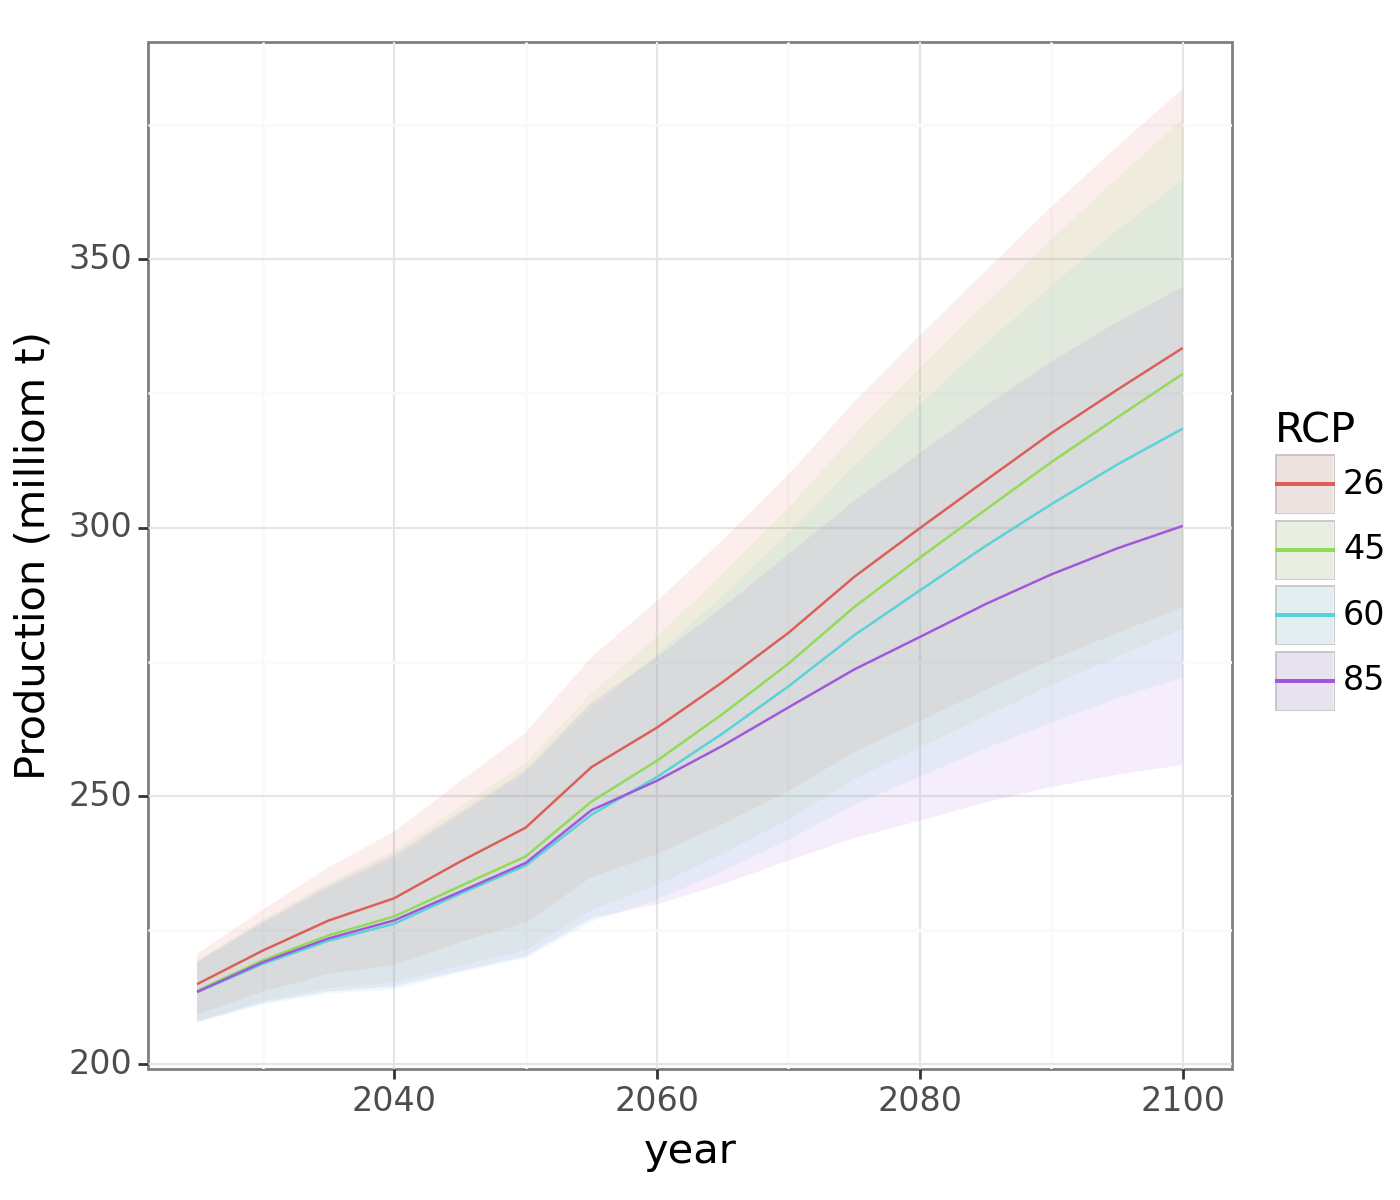

<Figure Size: (700 x 600)>

In [25]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (7, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 geom_ribbon(production_city_crop_water_sum_rcp,aes(x='final_year',ymin='final_reclamation_bot',
                        ymax='final_reclamation_top',fill='rcp'),alpha=0.1) +
 geom_line(production_city_crop_water_sum_rcp,aes(x='final_year',y='final_reclamation',color='rcp')) +

 # change legend name
 scale_fill_discrete(name='RCP') +
 scale_color_discrete(name='RCP') +

 theme_bw(base_size=15) + 
 ylab('Production (milliom t)') +
 xlab('year')
)

# show fig
g

In [26]:
g.save('../Figs/result_3_3_rcp_total_production.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_3_rcp_total_production.svg


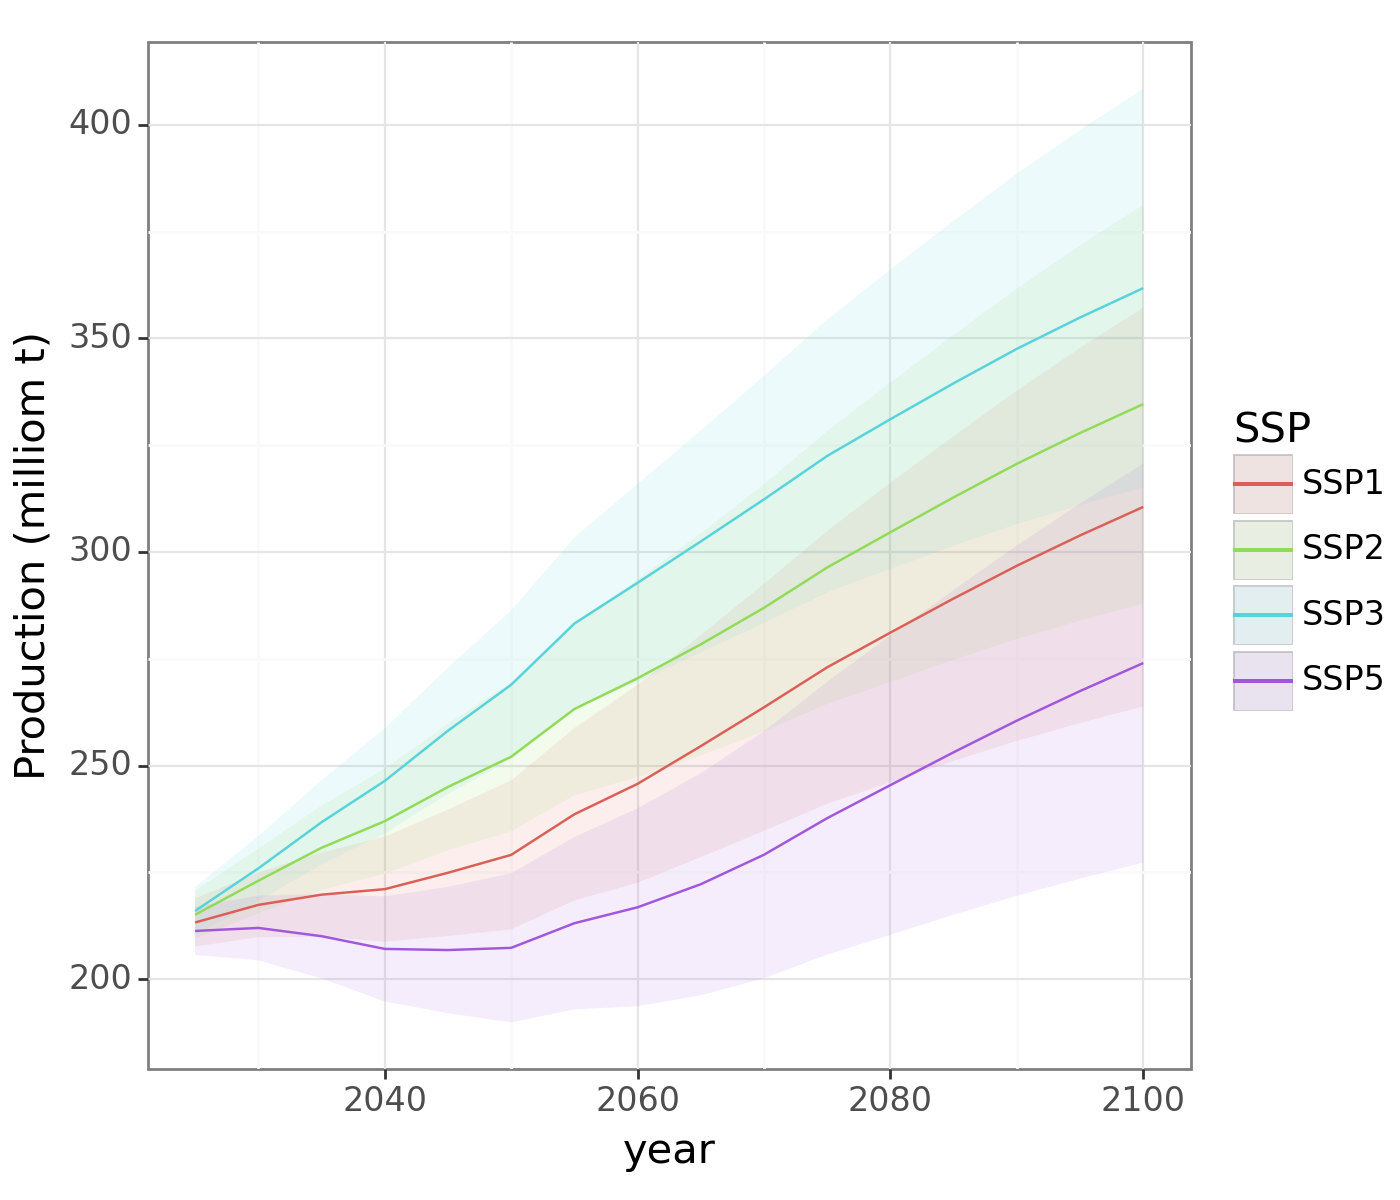

<Figure Size: (700 x 600)>

In [27]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (7, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 geom_ribbon(production_city_crop_water_sum_ssp,aes(x='final_year',ymin='final_reclamation_bot',
                         ymax='final_reclamation_top',fill='ssp'),alpha=0.1) +
 geom_line(production_city_crop_water_sum_ssp ,aes(x='final_year',y='final_reclamation',color='ssp')) +

 # change legend name
 scale_fill_discrete(name='SSP') +
 scale_color_discrete(name='SSP') + 

 theme_bw(base_size=15) + 
 theme() +
 ylab('Production (milliom t)') +
 xlab('year')
)

# show fig
g

In [28]:
g.save('../Figs/result_3_4_ssp_total_production.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_4_ssp_total_production.svg


##### 2-3) Compute the total impact of climate/tech/urbanization

Add properties for indicating colors

In [29]:
# compute the total crop production from city level records
production_city_df = production_city_crop_water.groupby(['rcp','ssp','year','final_year']).sum().reset_index()

# make cols for coloring
production_city_df['color_net'] = 'Net Change'
production_city_df['color_climate'] = 'Climate'
production_city_df['color_tech'] = 'Technology'
production_city_df['color_reclamation'] = 'Reclamation'
production_city_df['color_urban'] = 'Urbanization'

# make scenario form rcp-ssp
production_city_df['rcp'] = production_city_df['rcp'].astype(str)
production_city_df['Scenario'] = production_city_df.apply(lambda x:f"{x['ssp']}-{x['rcp']}",1)

# select the tier-1 ssp-rcp comninations
production_city_df_masked = production_city_df >> mask(eval(rules))

# get the mean values for all scenarios
production_city_df_masked_mean_scenario = production_city_df_masked.groupby(['year','final_year']).mean().reset_index()
production_city_df_masked_mean_scenario['color_net'] = 'Net Change'
production_city_df_masked_mean_scenario['color_climate'] = 'Climate'
production_city_df_masked_mean_scenario['color_tech'] = 'Technology'
production_city_df_masked_mean_scenario['color_reclamation'] = 'Reclamation'
production_city_df_masked_mean_scenario['color_urban'] = 'Urbanization'

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16160\21856828.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16160\21856828.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


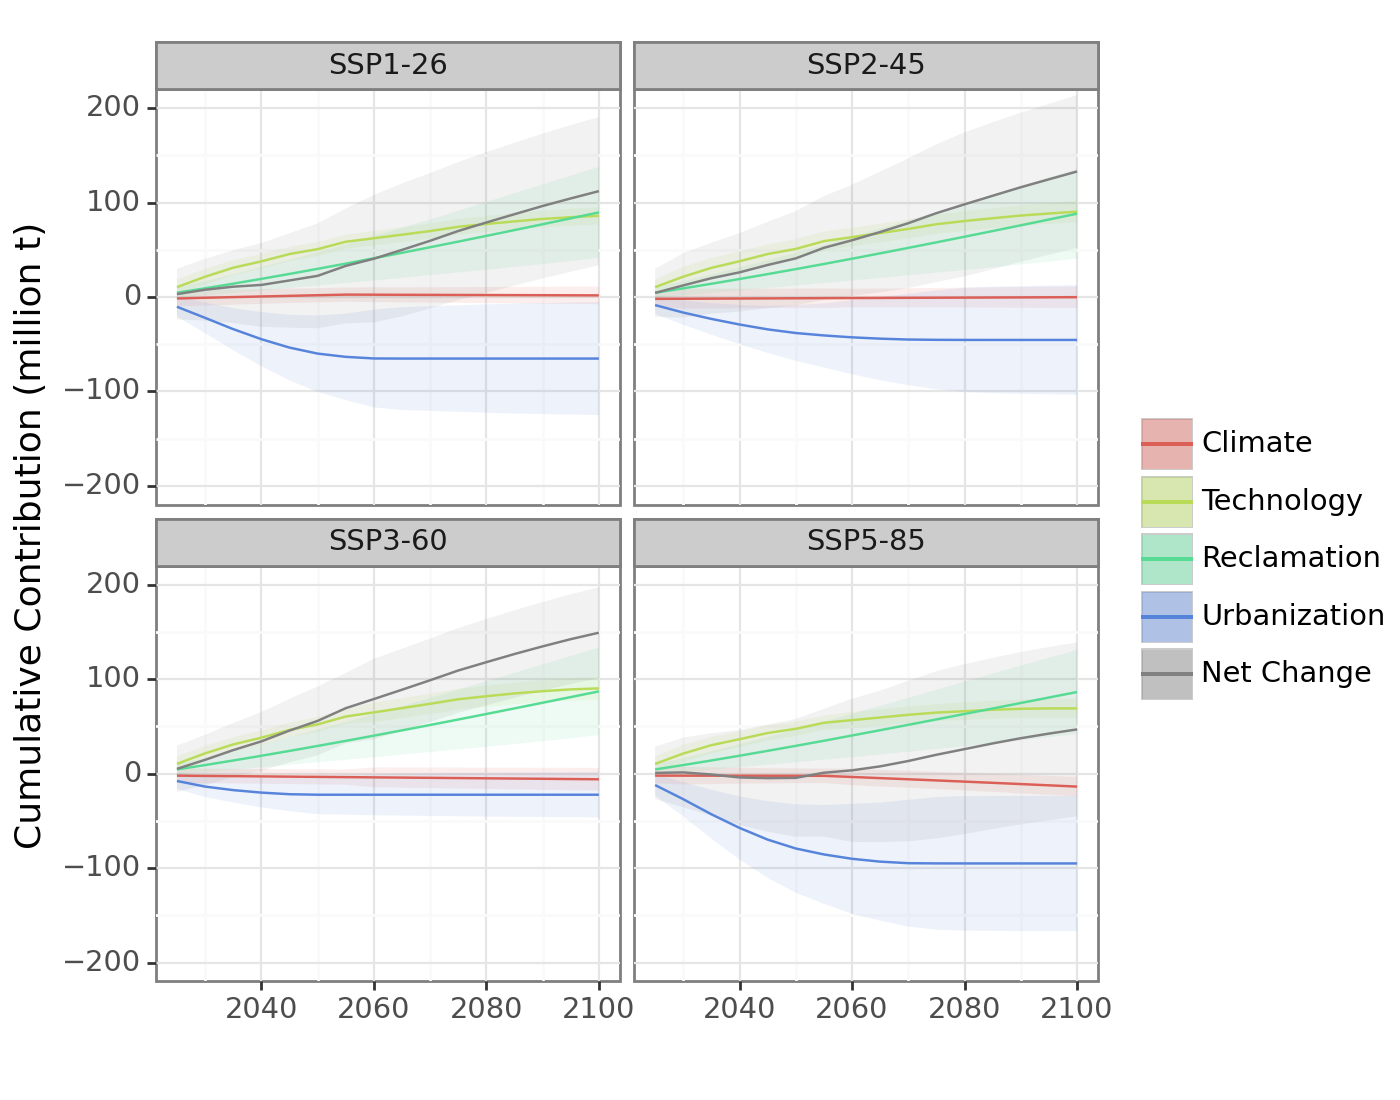

<Figure Size: (700 x 550)>

In [30]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (7, 5.5)
plotnine.options.dpi = 100

g = (ggplot() +
 geom_ribbon(production_city_df_masked,aes(x='final_year',
                      ymin='accum_climate_bot',
                      ymax='accum_climate_top',fill='color_climate'),alpha=0.1) +
 geom_ribbon(production_city_df_masked,aes(x='final_year',
                      ymin='accum_tech_bot',
                      ymax='accum_tech_top',fill='color_tech'),alpha=0.1) +
 geom_ribbon(production_city_df_masked,aes(x='final_year',
                      ymin='accum_reclamation_bot',
                      ymax='accum_reclamation_top',fill='color_reclamation'),alpha=0.1) +
 geom_ribbon(production_city_df_masked,aes(x='final_year',
                      ymin='accum_urban_bot',
                      ymax='accum_urban_top',fill='color_urban'),alpha=0.1) +
 geom_ribbon(production_city_df_masked,aes(x='final_year',
                      ymin='net_change_bot',
                      ymax='net_change_top',fill='color_net'),alpha=0.1) +     

 geom_line(production_city_df_masked,aes(x='final_year',y='accum_climate',color='color_climate')) +
 geom_line(production_city_df_masked,aes(x='final_year',y='accum_tech',color='color_tech')) +
 geom_line(production_city_df_masked,aes(x='final_year',y='accum_reclamation',color='color_reclamation')) +
 geom_line(production_city_df_masked,aes(x='final_year',y='accum_urban',color='color_urban')) +
 geom_line(production_city_df_masked,aes(x='final_year',y='net_change',color='color_net')) +

 # change legend name
 scale_fill_manual(values={'Climate':'#db5f57','Technology':'#b9db57','Reclamation':'#57db94',
              'Urbanization':'#5784db','Net Change':'grey'},
          name=' ') +
 scale_color_manual(values={'Climate':'#db5f57','Technology':'#b9db57','Reclamation':'#57db94',
              'Urbanization':'#5784db','Net Change':'grey'},
          name=' ') +  

 theme_bw(base_size=13) + 
 coord_cartesian(ylim=(-200,200)) +
#  theme(legend_title=element_blank(),legend_key_size=12,legend_text=element_text(size=10)) +
 ylab('Cumulative Contribution (million t)') +
 xlab(' ') +
 facet_wrap(['Scenario'],nrow=2)
)

# show fig
g

In [31]:
g.save('../Figs/result_3_5_1_climate_tech_urban_contribution.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 5.5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_5_1_climate_tech_urban_contribution.svg


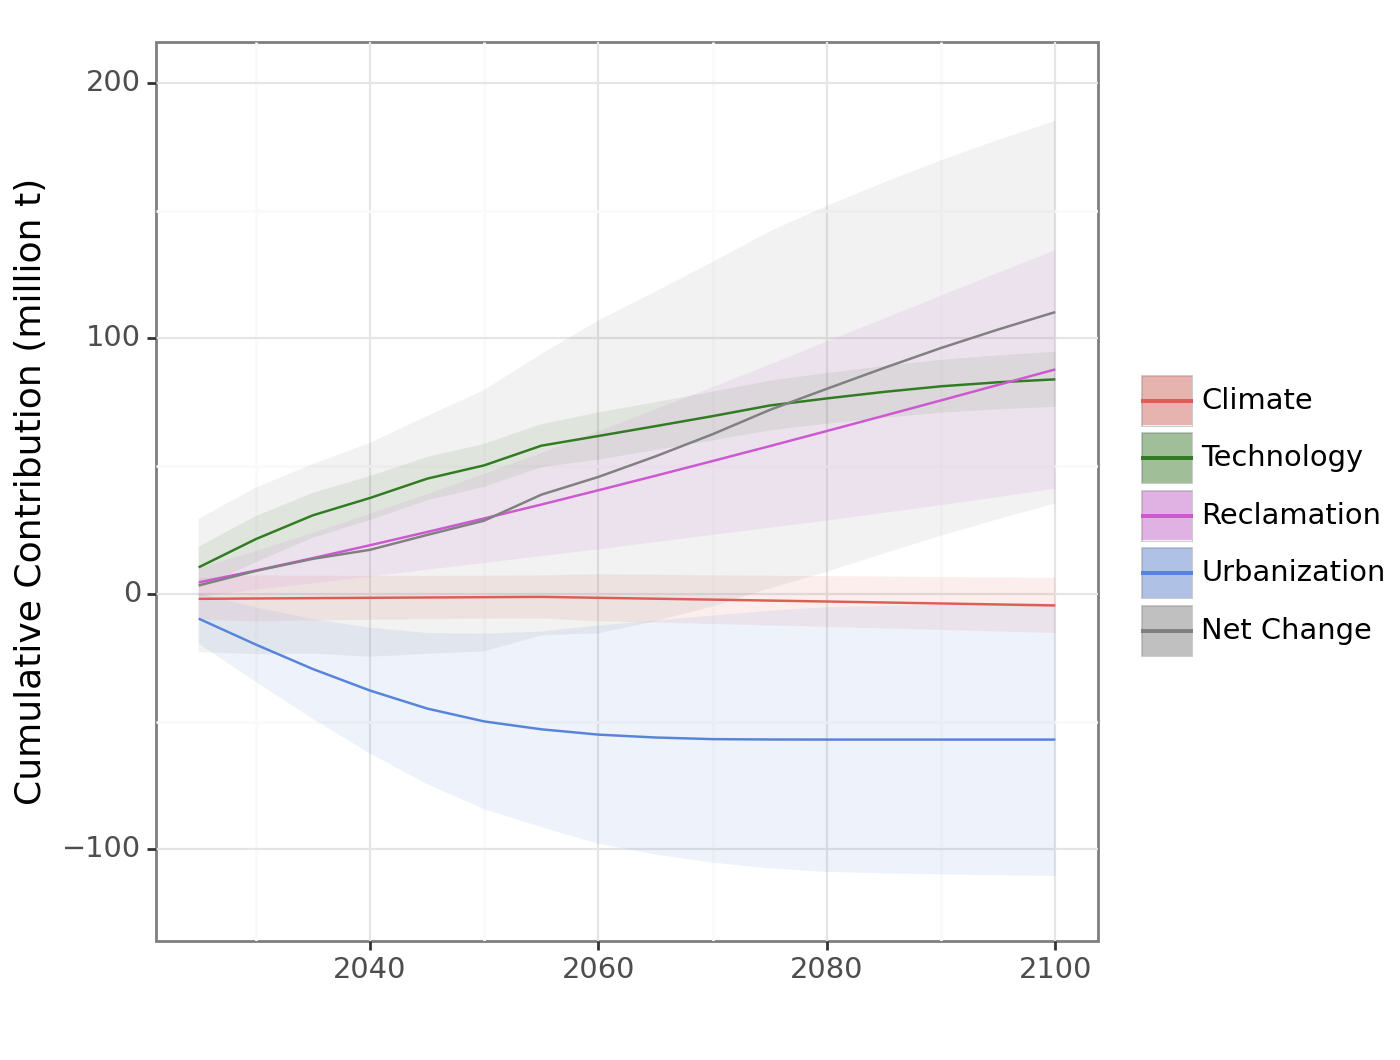

<Figure Size: (700 x 530)>

In [32]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (7, 5.3)
plotnine.options.dpi = 100

g = (ggplot(production_city_df_masked_mean_scenario) +
 geom_ribbon(aes(x='final_year',
          ymin='accum_climate_bot',
          ymax='accum_climate_top',fill='color_climate'),alpha=0.1) +
 geom_ribbon(aes(x='final_year',
          ymin='accum_tech_bot',
          ymax='accum_tech_top',fill='color_tech'),alpha=0.1) +
 geom_ribbon(aes(x='final_year',
          ymin='accum_reclamation_bot',
          ymax='accum_reclamation_top',fill='color_reclamation'),alpha=0.1) +
 geom_ribbon(aes(x='final_year',
          ymin='accum_urban_bot',
          ymax='accum_urban_top',fill='color_urban'),alpha=0.1) +
 geom_ribbon(aes(x='final_year',
          ymin='net_change_bot',
          ymax='net_change_top',fill='color_net'),alpha=0.1) +     

 geom_line(aes(x='final_year',y='accum_climate',color='color_climate')) +
 geom_line(aes(x='final_year',y='accum_tech',color='color_tech')) +
 geom_line(aes(x='final_year',y='accum_reclamation',color='color_reclamation')) +
 geom_line(aes(x='final_year',y='accum_urban',color='color_urban')) +
 geom_line(aes(x='final_year',y='net_change',color='color_net')) +

 # change legend name
 scale_fill_manual(values={'Climate':'#db5f57','Technology':'#317b22','Reclamation':'#cc59d2',
              'Urbanization':'#5784db','Net Change':'grey'},
          name=' ') +
 scale_color_manual(values={'Climate':'#db5f57','Technology':'#317b22','Reclamation':'#cc59d2',
              'Urbanization':'#5784db','Net Change':'grey'},
          name=' ') +  

 theme_bw(base_size=13) + 
 coord_cartesian(ylim=(-120,200)) +
#  theme(legend_title=element_blank(),legend_key_size=12,legend_text=element_text(size=10)) +
 ylab('Cumulative Contribution (million t)') +
 xlab(' ') 
)

# show fig
g

In [33]:
g.save('../Figs/result_3_5_2_climate_tech_urban_contribution.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 5.3 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_5_2_climate_tech_urban_contribution.svg


##### 2-4) Compute the crop/water impacts

In [51]:
# compute the total crop production from city level records
production_city_df_crop = production_city_crop_water\
                .groupby(['rcp','ssp','year','final_year','crop','Scenario']).sum().reset_index() \
                >> mask(eval(rules))
production_city_df_crop_mean_scenario = production_city_df_crop\
                .groupby(['year','final_year','crop']).mean().reset_index()

production_city_df_water = production_city_crop_water\
                .groupby(['rcp','ssp','year','final_year','water','Scenario']).sum().reset_index() \
                >> mask(eval(rules))
production_city_df_water_mean_scenario = production_city_df_water\
                .groupby(['year','final_year','water']).mean().reset_index()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11816\2809859293.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11816\2809859293.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11816\2809859293.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11816\28098592

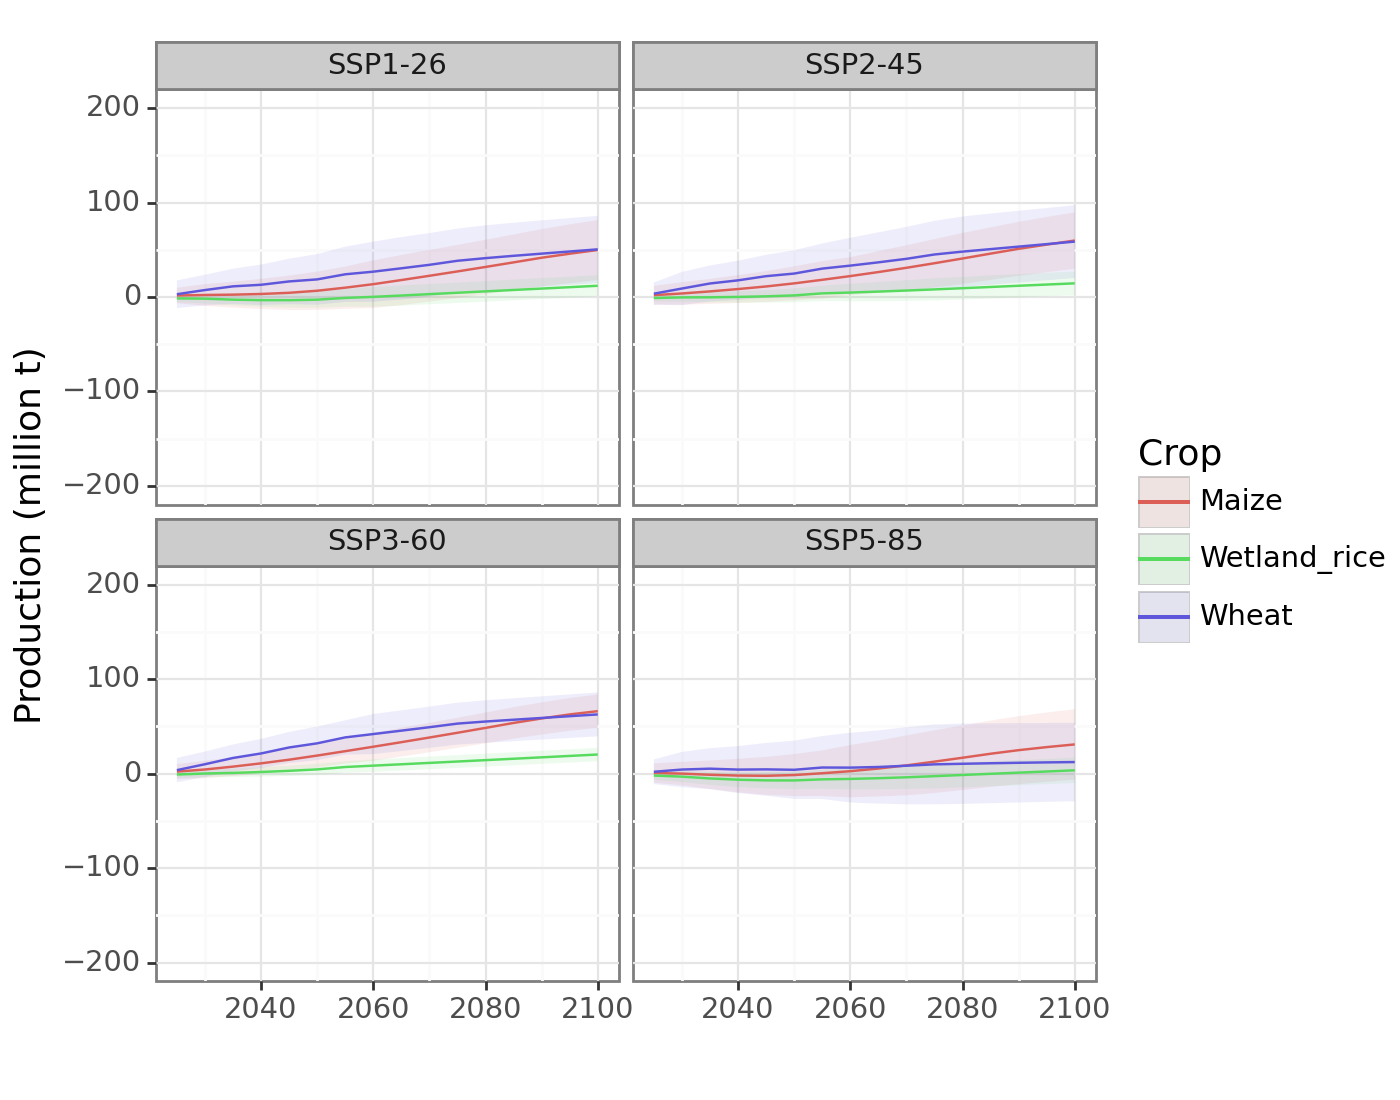

<Figure Size: (700 x 550)>

In [52]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (7, 5.5)
plotnine.options.dpi = 100

g = (ggplot() +
 geom_ribbon(production_city_df_crop,aes(x='final_year',ymin='net_change_bot',
                      ymax='net_change_top',fill='crop'),alpha=0.1) +
 geom_line(production_city_df_crop,aes(x='final_year',y='net_change',color='crop')) +
 theme_bw(base_size=13) + 
#  theme(axis_text_x=element_text(rotation=30)) +

 # change legend name
 scale_fill_discrete(name='Crop') +
 scale_color_discrete(name='Crop') +

 ylab('Production (million t)') +
 xlab(' ') +
 coord_cartesian(ylim=(-200,200)) +
 facet_wrap(['Scenario'],nrow=2)
)

# show fig
g

In [53]:
g.save('../Figs/result_3_6_1_crop_contribution.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 5.5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_6_1_crop_contribution.svg


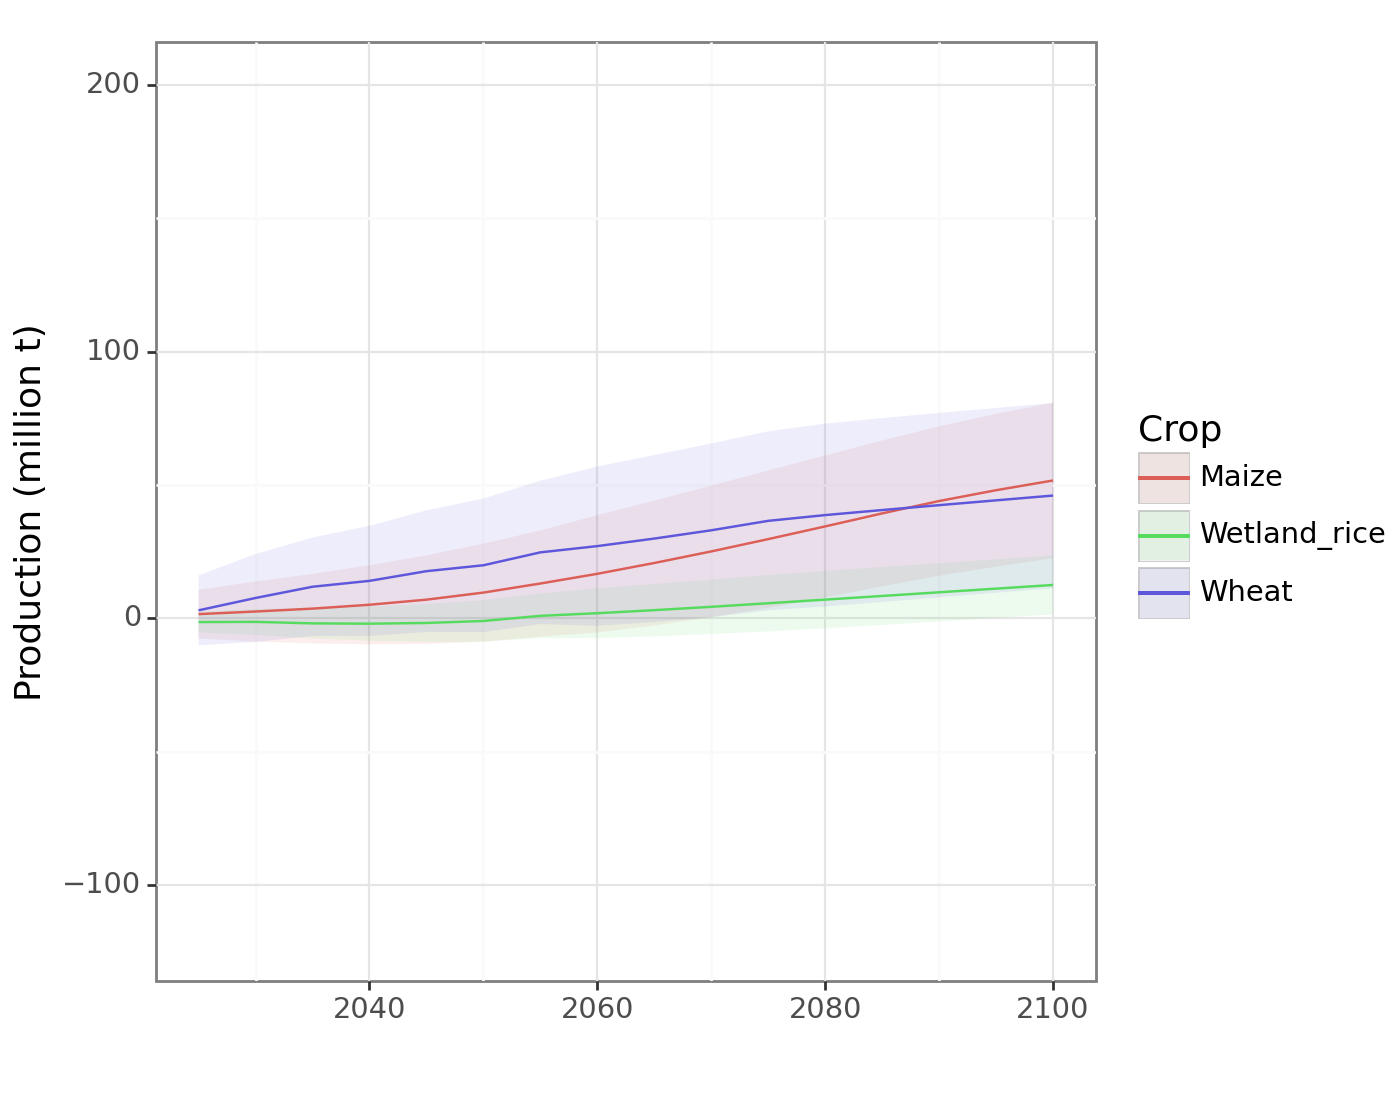

<Figure Size: (700 x 550)>

In [55]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (7, 5.5)
plotnine.options.dpi = 100

g = (ggplot() +
 geom_ribbon(production_city_df_crop_mean_scenario,aes(x='final_year',ymin='net_change_bot',
                      ymax='net_change_top',fill='crop'),alpha=0.1) +
 geom_line(production_city_df_crop_mean_scenario,aes(x='final_year',y='net_change',color='crop')) +
 theme_bw(base_size=13) + 
#  theme(axis_text_x=element_text(rotation=30)) +

 # change legend name
 scale_fill_discrete(name='Crop') +
 scale_color_discrete(name='Crop') +

 ylab('Production (million t)') +
 xlab(' ') +
 coord_cartesian(ylim=(-120,200))
)

# show fig
g

In [56]:
g.save('../Figs/result_3_6_2_crop_contribution.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 5.5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_6_2_crop_contribution.svg


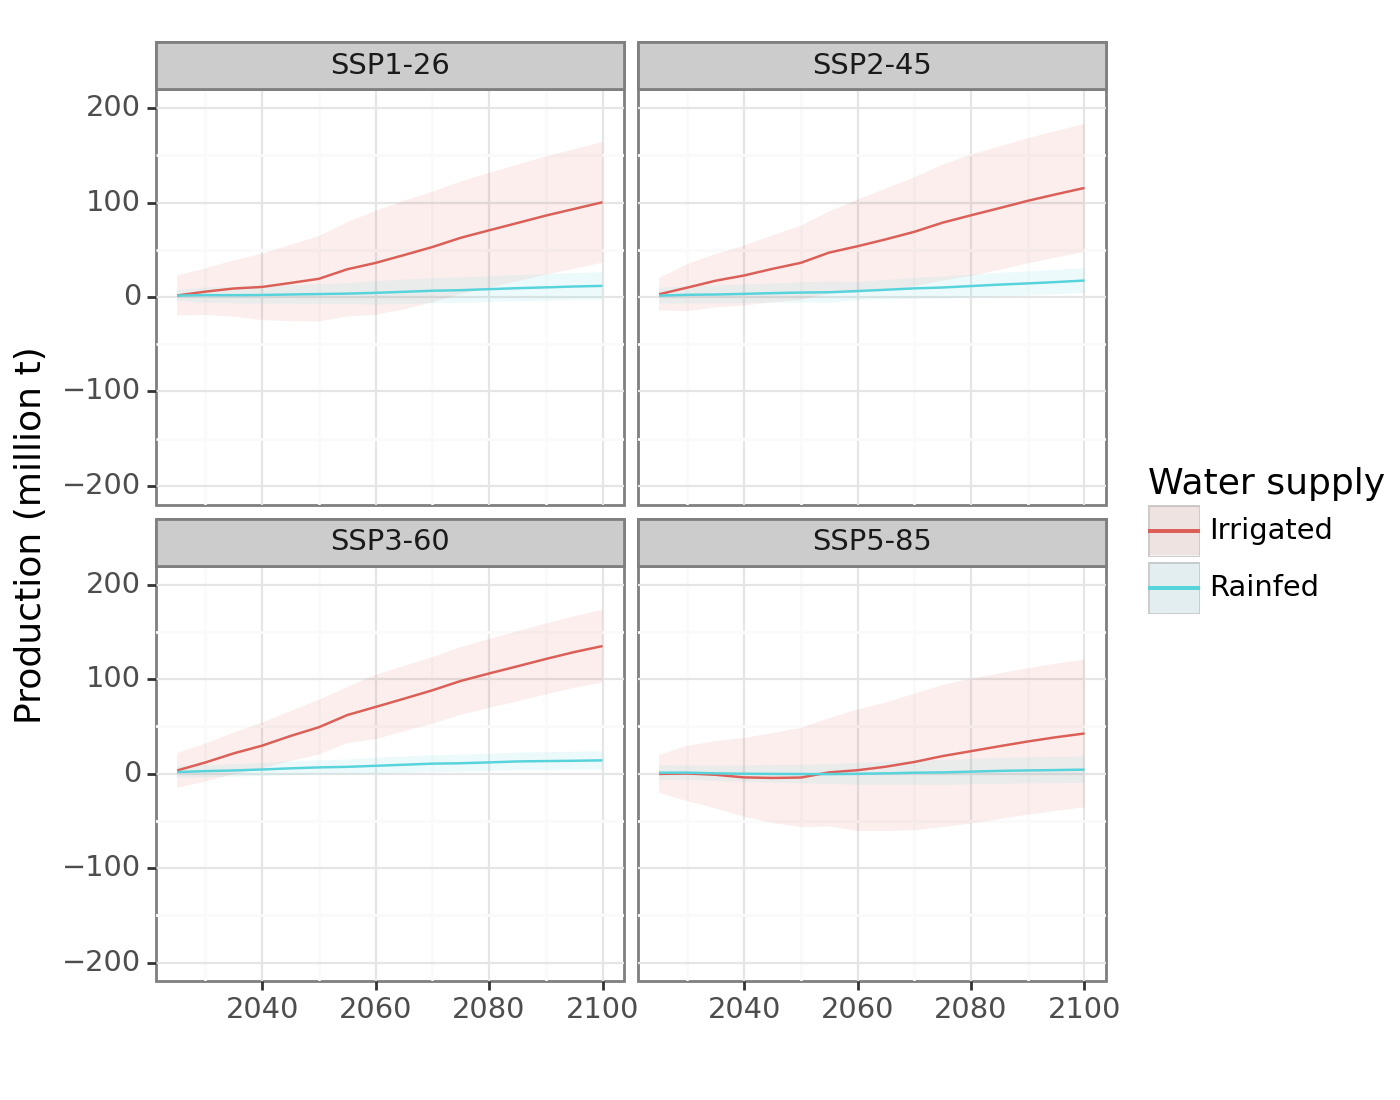

<Figure Size: (700 x 550)>

In [58]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (7, 5.5)
plotnine.options.dpi = 100

g = (ggplot() +
 geom_ribbon(production_city_df_water,aes(x='final_year',ymin='net_change_bot',
                      ymax='net_change_top',fill='water'),alpha=0.1) +
 geom_line(production_city_df_water,aes(x='final_year',y='net_change',color='water')) +
 theme_bw(base_size=13) + 
#  theme(axis_text_x=element_text(rotation=30),legend_position=(0.5,-0.05)) +
 coord_cartesian(ylim=(-200,200)) +

 # change legend name
 scale_fill_discrete(name='Water supply') +
 scale_color_discrete(name='Water supply') +

 ylab('Production (million t)') +
 xlab(' ') +
 facet_wrap(['Scenario'],nrow=2)
)

# show fig
g

In [59]:
g.save('../Figs/result_3_7_1_water_contribution.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 5.5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_7_1_water_contribution.svg


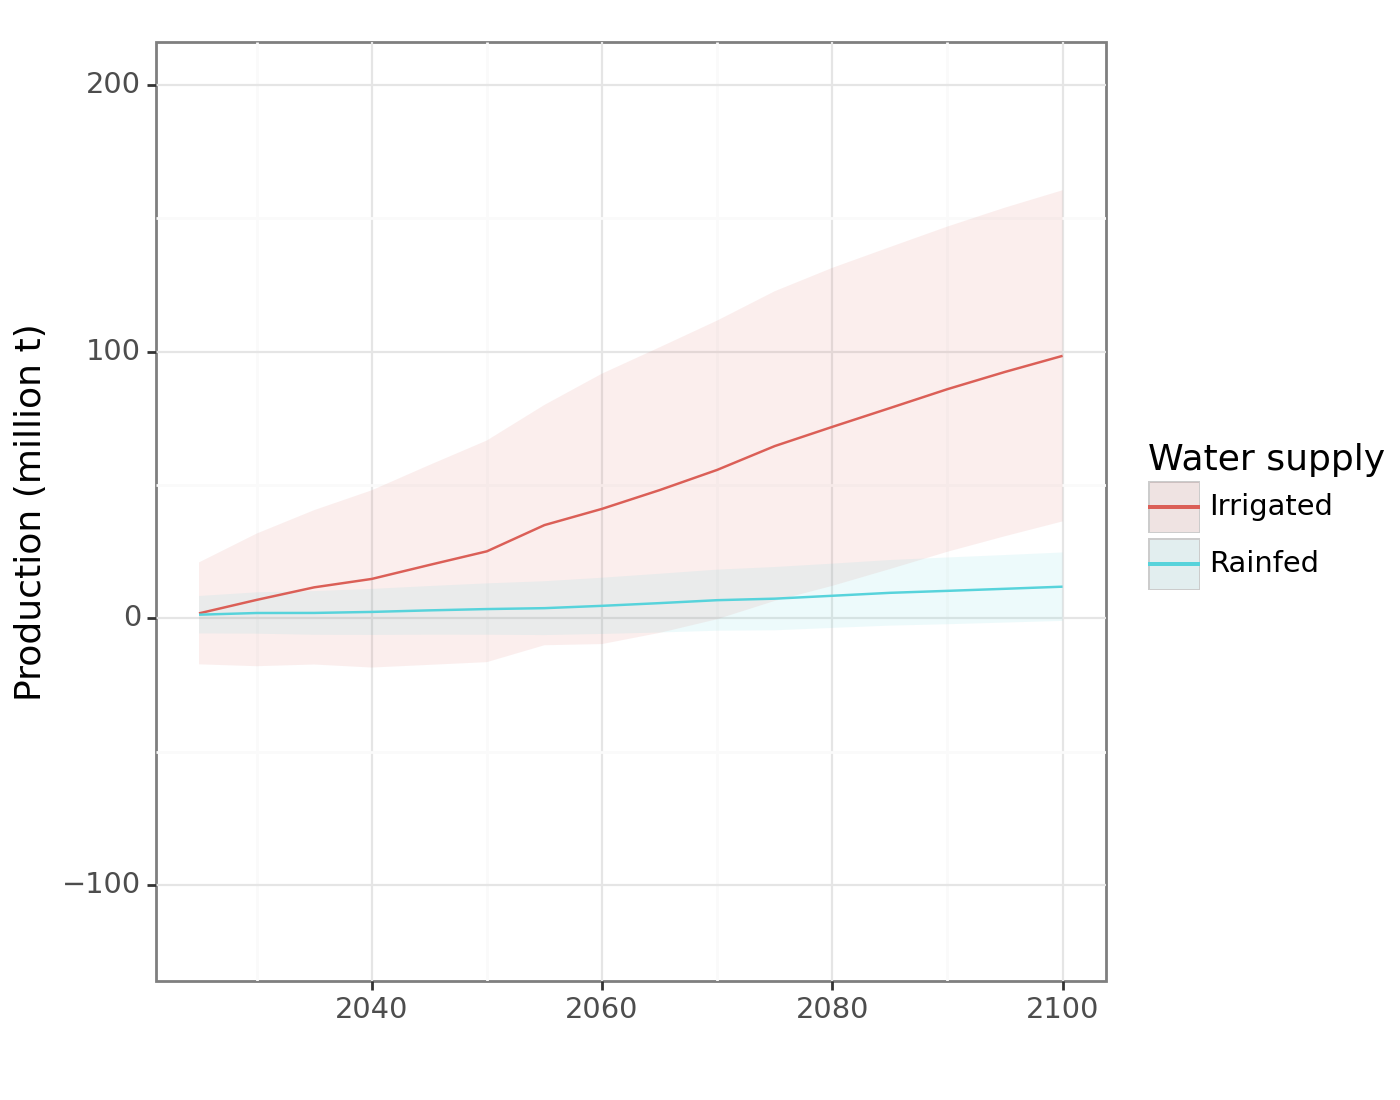

<Figure Size: (700 x 550)>

In [61]:
# plot the yearbook/GAEZ/GYGA data
plotnine.options.figure_size = (7,5.5)
plotnine.options.dpi = 100

g = (ggplot() +
 geom_ribbon(production_city_df_water_mean_scenario,aes(x='final_year',ymin='net_change_bot',
                      ymax='net_change_top',fill='water'),alpha=0.1) +
 geom_line(production_city_df_water_mean_scenario,aes(x='final_year',y='net_change',color='water')) +
 theme_bw(base_size=13) + 
#  theme(axis_text_x=element_text(rotation=30),legend_position=(0.5,-0.05)) +

 # change legend name
 scale_fill_discrete(name='Water supply') +
 scale_color_discrete(name='Water supply') +
 coord_cartesian(ylim=(-120,200)) +
 ylab('Production (million t)') +
 xlab(' ') 
)

# show fig
g

In [62]:
g.save('../Figs/result_3_7_2_water_contribution.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 5.5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_3_7_2_water_contribution.svg


#### 3) visualize the climate/tech/urban impacts on each city

In [63]:
property_to_plot = ['accum_climate','accum_tech','accum_urban','net_change','final_reclamation',]

In [ ]:
out_dfs = []
production_df_grouped = production_city_crop_water.groupby(['rcp','ssp','year','final_year','Province'])

for idx,df in tqdm(production_df_grouped,total=len(production_df_grouped)):
  # get properties
  rcp,ssp,year,year,Province = idx

  # get the shp from NCP_shp
  shp = (NCP_shp >> mask(X.CityNameC == Province))['geometry'].tolist()[0]
  
  # determine the properties for plot
  loop_dict = {p:[df[p].sum()] for p in property_to_plot}
  loop_dict['geometry'] = [shp]

  loop_df = pd.DataFrame(loop_dict)
  loop_df[['rcp','ssp','year','final_year','Province']] = idx

  # record the loop_dict as a df
  out_dfs.append(loop_df)

  0%|          | 0/24320 [00:00<?, ?it/s]

In [ ]:
province_total_val_shp = pd.concat(out_dfs)
province_total_val_shp_grouped = province_total_val_shp.groupby(['rcp','ssp','final_year'])

In [ ]:
%matplotlib notebook
for idx,df in tqdm(province_total_val_shp_grouped,total=len(province_total_val_shp_grouped)):
  rcp,ssp,year = idx
  df = df.set_geometry('geometry')


  for p in property_to_plot:

    val_min = (production_city_crop_water >> mask(X.rcp == rcp, X.ssp == ssp))[p].min()
    val_max = (production_city_crop_water >> mask(X.rcp == rcp, X.ssp == ssp))[p].max()

    # making plots
    fig,ax = plt.subplots(figsize=(16,9))
    fig_out = df.plot(ax=ax,column=p,legend=True,cmap='Spectral_r',vmin=val_min,vmax=val_max)
    ax.text(110.7,41,year,size=25)
    ax.text(110.7,40,f"rcp={rcp}",size=13)
    ax.text(110.7,39.5,f"ssp={ssp}",size=13)


    ax.set_title(p,size=20)

    # save plots
    plot_name = "_".join([p,str(rcp),ssp,str(year)])
    fig.savefig(f"./gifs/{plot_name}.png")

    plt.close(fig)